NaN checks completed.
NaN checks completed.


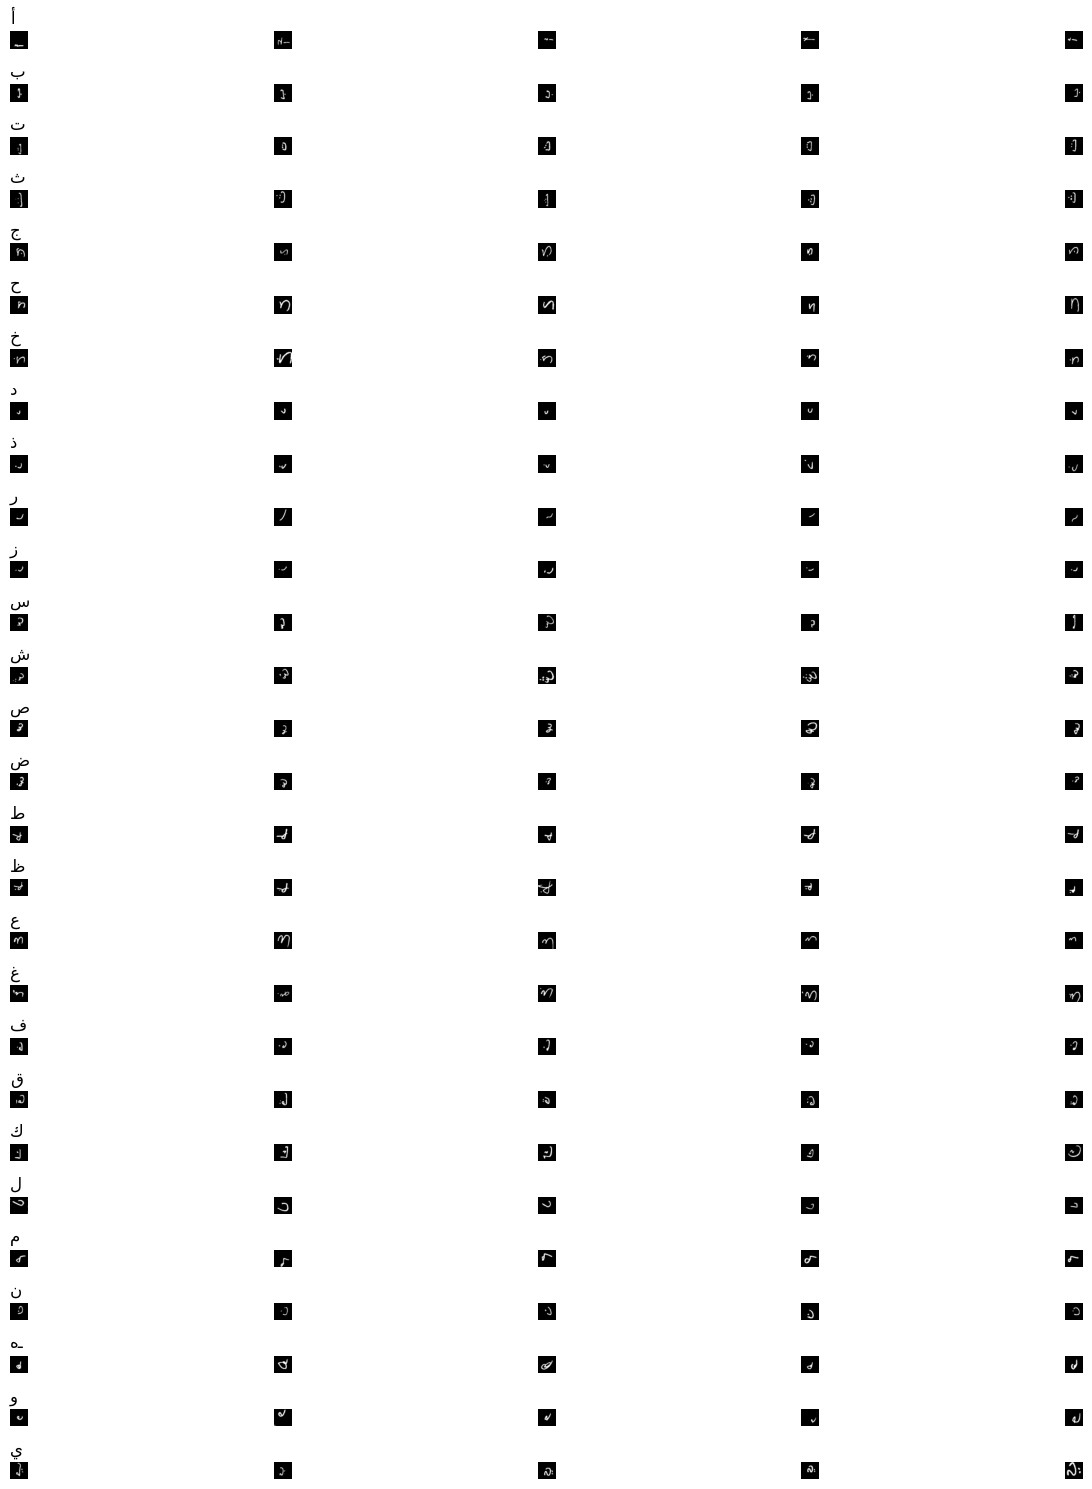

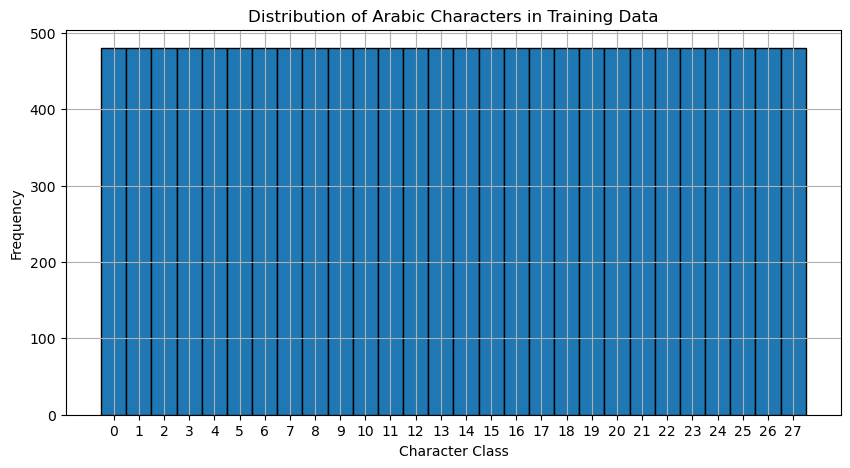

In [10]:
import pandas as pd                     # For data manipulation and analysis
import numpy as np                      # Numpy library for numerical operations
import matplotlib.pyplot as plt         # matplotlib.pyplot for data visualization
from sklearn.model_selection import train_test_split  # Importing train_test_split function from sklearn.model_selection for splitting data
from tensorflow.keras.models import Sequential         # Importing Sequential class from tensorflow.keras.models for creating a sequential model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization  # Importing layers from tensorflow.keras.layers for building the model
from tensorflow.keras.utils import to_categorical     # Importing to_categorical function from tensorflow.keras.utils for one-hot encoding
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau  # Importing callbacks for early stopping and reducing learning rate
from tensorflow.keras.preprocessing.image import ImageDataGenerator    # Importing ImageDataGenerator for image data augmentation
from sklearn.utils.class_weight import compute_class_weight  # Importing compute_class_weight function for computing class weights

# Path to the dataset
x_train_path = "C:/Users/bouma/Downloads/archive/csvTrainImages 13440x1024.csv"  # Path to the training images
y_train_path = "C:/Users/bouma/Downloads/archive/csvTrainLabel 13440x1.csv"      # Path to the training labels
x_test_path = "C:/Users/bouma/Downloads/archive/csvTestImages 3360x1024.csv"     # Path to the test images
y_test_path = "C:/Users/bouma/Downloads/archive/csvTestLabel 3360x1.csv"          # Path to the test labels

# Load the datasets
x_train = pd.read_csv(x_train_path, header=None).values.astype('float32')  # Reading and converting training images to float32 for data consistency
y_train = pd.read_csv(y_train_path, header=None).values.astype('int32') - 1  # Reading and converting training labels to int32 and subtracting 1 so that the labels start from zero
                                                                             # to align the label encoding with zero-based indexing 
x_test = pd.read_csv(x_test_path, header=None).values.astype('float32')    # Reading and converting test images to float32
y_test = pd.read_csv(y_test_path, header=None).values.astype('int32') - 1    # Reading and converting test labels to int32 and subtracting 1

# Checking and handling NaN values
# Here we Check for NaN values in the input data and handle them by replacing NaNs with the mean of each column.
    
def check_and_handle_nans(x, y):
    
    if np.isnan(x).sum() > 0 or np.isnan(y).sum() > 0:  # Checking if there are NaN values in x or y
        print(" Start...")  # Printing message indicating NaN values are being handled
        nan_cols = np.any(np.isnan(x), axis=0)  # Checking for NaN values in each column of x
        mean_values = np.nanmean(x, axis=0)     # Calculating mean values of each column of x
        inds = np.where(np.isnan(x))            # Finding indices of NaN values in x
        x[inds] = np.take(mean_values, inds[1])  # Replacing NaN values with mean values in x
    print("NaN checks completed.")  # Printing message indicating NaN check is completed

check_and_handle_nans(x_train, y_train)  # Calling the function to check and handle NaN values in training data
check_and_handle_nans(x_test, y_test)    # Calling the function to check and handle NaN values in test data

# Define the names of the Arabic characters so we ca use it later to know the character for each label.
character_names = ['أ', 'ب', 'ت', 'ث', 'ج', 'ح', 'خ', 'د', 'ذ', 'ر', 'ز', 'س', 'ش', 'ص', 'ض', 'ط', 'ظ', 'ع', 'غ', 'ف', 'ق', 'ك', 'ل', 'م', 'ن', 'هـ', 'و', 'ي']

# Plot a grid of sample images with their corresponding character names
num_classes = 28  # Number of Arabic characters
num_samples_per_class = 5  # Number of samples per class to display
fig, axes = plt.subplots(nrows=num_classes, ncols=num_samples_per_class, figsize=(15, 15))  # Creating subplots for images
for i in range(num_classes):  # Looping over each class
    class_indices = np.where(y_train.flatten() == i)[0]  # Getting indices of samples belonging to class i
    for j in range(num_samples_per_class):  # Looping over each sample per class
        img_index = np.random.choice(class_indices)  # Selecting a random sample index
        ax = axes[i, j]  # Getting the axis for the current subplot
        ax.imshow(x_train[img_index].reshape(32, 32), cmap='gray')  # Displaying the image on the subplot
        ax.axis('off')  # Turning off axis labels
        if j == 0:  # If it's the first image in the row
            ax.set_title(character_names[i], fontsize=12, loc='left')  # Setting the title to the character name
plt.tight_layout()  # Adjusting subplot layout to fit titles
plt.show()  # Displaying the plot



# Reshape the data to fit the model and normalize pixel values
x_train = x_train.reshape(-1, 32, 32, 1) / 255.0  # Reshaping and normalizing training images 
# -1 in this position allows to reshape the array while keeping the total number of elements unchanged.
# 32: the height of the image (32 pixels).
# 32: the width of the image (32 pixels).
# 1: the number of channels in the image. Since the images are grayscale, there is only one channel. It si equal to 3 for RGB images.
x_test = x_test.reshape(-1, 32, 32, 1) / 255.0    # Reshaping and normalizing test images

# Convert labels to categorical
y_train = to_categorical(y_train, num_classes=28)  # Converting training labels to categorical
y_test = to_categorical(y_test, num_classes=28)    # Converting test labels to categorical

# Plot the distribution of characters in the training data
plt.figure(figsize=(10, 5))  # Creating a figure for the plot
plt.hist(np.argmax(y_train, axis=1), bins=np.arange(29)-0.5, ec='black')  # Creating a histogram of character frequencies
plt.title('Distribution of Arabic Characters in Training Data')  # Setting the title of the plot
plt.xlabel('Character Class')  # Setting the x-axis label
plt.ylabel('Frequency')         # Setting the y-axis label
plt.xticks(np.arange(28))       # Setting the x-axis ticks
plt.grid(True)                  # Displaying grid lines
plt.show()                      # Displaying the plot


In [11]:

#This is for data augmentation to avoid overfitting
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images



Epoch 1/30


C:\Users\bouma\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


  3/420 ━━━━━━━━━━━━━━━━━━━━ 14s 34ms/step - accuracy: 0.0434 - loss: 4.7671

C:\Users\bouma\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


420/420 ━━━━━━━━━━━━━━━━━━━━ 17s 33ms/step - accuracy: 0.1393 - loss: 3.6035 - val_accuracy: 0.0908 - val_loss: 3.9855 - learning_rate: 0.0010
Epoch 2/30
420/420 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.4094 - loss: 1.8474 - val_accuracy: 0.7375 - val_loss: 0.7804 - learning_rate: 0.0010
Epoch 3/30
420/420 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - accuracy: 0.5577 - loss: 1.3408 - val_accuracy: 0.8110 - val_loss: 0.5355 - learning_rate: 0.0010
Epoch 4/30
420/420 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - accuracy: 0.6415 - loss: 1.0844 - val_accuracy: 0.8685 - val_loss: 0.3800 - learning_rate: 0.0010
Epoch 5/30
420/420 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - accuracy: 0.6860 - loss: 0.9445 - val_accuracy: 0.8420 - val_loss: 0.4736 - learning_rate: 0.0010
Epoch 6/30
420/420 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - accuracy: 0.7172 - loss: 0.8405 - val_accuracy: 0.8283 - val_loss: 0.4253 - learning_rate: 0.0010
Epoch 7/30
420/420 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - accuracy: 0.7471 - loss: 0.7457

Test accuracy: 0.9348214268684387


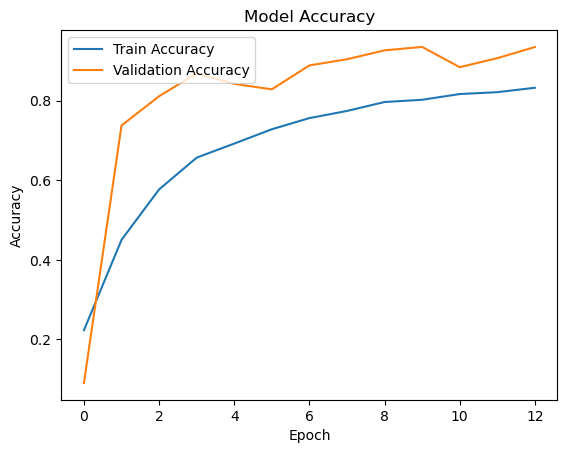

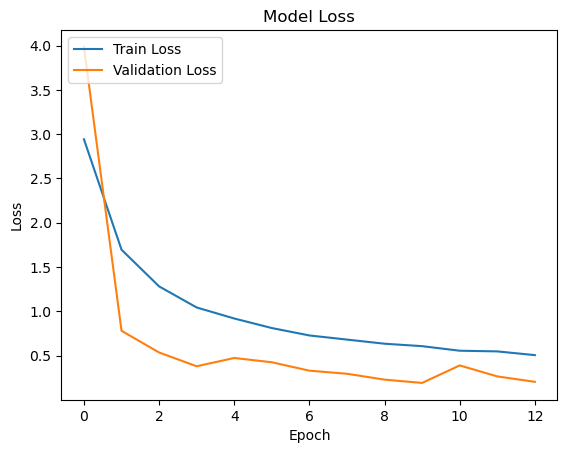

In [13]:
# Define the CNN model architecture
model = Sequential([
    Conv2D(32, (3, 3), padding='same', input_shape=(32, 32, 1), activation='relu'),  # Convolutional layer with 32 filters and a 3x3 kernel, using 'same' padding
    BatchNormalization(),  # Batch normalization layer
    MaxPooling2D(pool_size=(2, 2)),  # Max pooling layer with a 2x2 pool size
    Dropout(0.3),  # Dropout layer with a dropout rate of 0.3 to prevent overfitting

    Conv2D(64, (3, 3), activation='relu'),  # Second convolutional layer with 64 filters and a 3x3 kernel
    BatchNormalization(),  # Batch normalization layer
    MaxPooling2D(pool_size=(2, 2)),  # Max pooling layer with a 2x2 pool size
    Dropout(0.3),  # Dropout layer with a dropout rate of 0.3

    Conv2D(128, (3, 3), activation='relu'),  # Third convolutional layer with 128 filters and a 3x3 kernel
    BatchNormalization(),  # Batch normalization layer
    MaxPooling2D(pool_size=(2, 2)),  # Max pooling layer with a 2x2 pool size
    Dropout(0.4),  # Dropout layer with a dropout rate of 0.4

    Flatten(),  # Flatten layer to convert 2D output to 1D
    Dense(256, activation='relu'),  # Dense layer with 256 units and a ReLU activation function
    BatchNormalization(),  # Batch normalization layer
    Dropout(0.5),  # Dropout layer with a dropout rate of 0.5
    Dense(28, activation='softmax')  # Output layer with 28 units (number of classes) and a softmax activation function
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Compute class weights for balancing the classes
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(np.argmax(y_train, axis=1)), y=np.argmax(y_train, axis=1))
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

# Define callbacks for early stopping and reducing learning rate on plateau
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.01)

# Fit the model on the batches generated by datagen.flow()
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=32),  # Data generator for training data
    epochs=30,  # Number of epochs for training
    validation_data=(x_test, y_test),  # Validation data
    callbacks=[early_stopping, reduce_lr],  # Callbacks for early stopping and reducing learning rate
    class_weight=class_weights_dict  # Class weights for balancing classes
)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print('Test accuracy:', test_accuracy)

# Save the trained model
model.save('path_to_save_your_model/my_arabic_recognition_model.h5')

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step


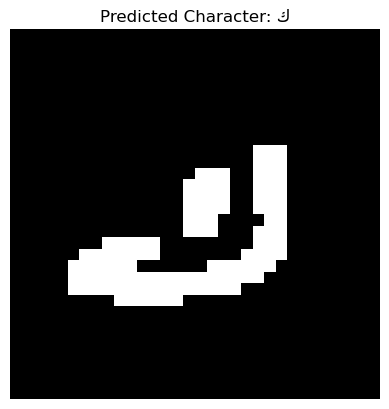

In [14]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import matplotlib.pyplot as plt
import cv2

# Here we are evaluating our model. We are uploading a picture of a random character and see if the model recognizes it or not

test_image_path = r"C:\Users\bouma\Downloads\archive\Test Images 3360x32x32\test\id_995_label_22.png"

test_image = cv2.imread(test_image_path, cv2.IMREAD_GRAYSCALE)
test_image_resized = cv2.resize(test_image, (32, 32))

# Preprocess the image (reshaping, normalization)
test_image_resized = test_image_resized.reshape(1, 32, 32, 1).astype('float32') / 255.0

# Predict the class
prediction = model.predict(test_image_resized)

predicted_class = np.argmax(prediction, axis=1)[0]


# Map the predicted label to your Arabic characters
arabic_characters = ["أ","ب","ت","ث","ج","ح","خ","د","ذ","ر","ز","س","ش","ص","ض","ط","ظ","ع","غ","ف","ق","ك","ل","م","ن","ه","و","ي"]
predicted_character = arabic_characters[predicted_class]


# Show the image and prediction
plt.imshow(test_image, cmap='gray')
plt.title(f'Predicted Character: {predicted_character}')
plt.axis('off')
plt.show()



In [15]:
#Some of the images were misclassified when testing the model so we correct their kabel to be correclty recognized and we add it to the training daatset
#to increase its recongition of chacacters with different features

misclassified_image_path =  r"C:\Users\bouma\Downloads\archive\Test Images 3360x32x32\test\id_995_label_22.png"
correct_label_index = 21  


misclassified_image = cv2.imread(misclassified_image_path, cv2.IMREAD_GRAYSCALE)
misclassified_image_resized = cv2.resize(misclassified_image, (32, 32))
misclassified_image_resized = misclassified_image_resized.reshape(1, 32, 32, 1).astype('float32') / 255.0


x_train = np.append(x_train, misclassified_image_resized, axis=0)
y_train = np.append(y_train, to_categorical([correct_label_index], num_classes=28), axis=0)




# Re-train the model with the updated training data

model.fit(x_train, y_train, epochs=30, validation_data=(x_test, y_test), callbacks=[early_stopping, reduce_lr])

# Evaluate the updated model
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print('Updated Test accuracy:', test_accuracy)
#we got a Test accuracy: 0.9675595164299011

Epoch 1/30
421/421 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - accuracy: 0.8681 - loss: 0.4118 - val_accuracy: 0.9378 - val_loss: 0.1893 - learning_rate: 0.0010
Epoch 2/30
421/421 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - accuracy: 0.8801 - loss: 0.3544 - val_accuracy: 0.9479 - val_loss: 0.1690 - learning_rate: 0.0010
Epoch 3/30
421/421 ━━━━━━━━━━━━━━━━━━━━ 12s 28ms/step - accuracy: 0.8861 - loss: 0.3423 - val_accuracy: 0.9274 - val_loss: 0.2166 - learning_rate: 0.0010
Epoch 4/30
421/421 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.8911 - loss: 0.3409 - val_accuracy: 0.9452 - val_loss: 0.1834 - learning_rate: 0.0010
Epoch 5/30
421/421 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - accuracy: 0.9083 - loss: 0.2883 - val_accuracy: 0.9482 - val_loss: 0.1810 - learning_rate: 0.0010
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9426 - loss: 0.1869
Updated Test accuracy: 0.9479166865348816


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


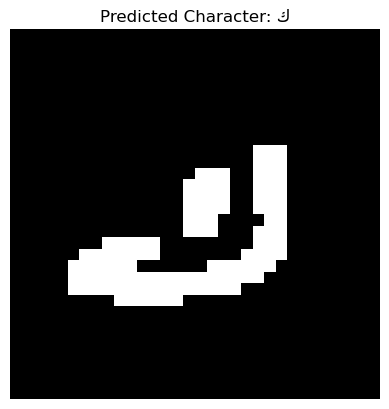

In [16]:
# Import necessary libraries
from tensorflow.keras.preprocessing.image import img_to_array, load_img  # Image preprocessing utilities
import matplotlib.pyplot as plt  # Plotting library
import cv2  # OpenCV for image processing

# Path to the test image
test_image_path = r"C:\Users\bouma\Downloads\archive\Test Images 3360x32x32\test\id_995_label_22.png"

# Load the image and convert it to grayscale
test_image = cv2.imread(test_image_path, cv2.IMREAD_GRAYSCALE)

# Resize the image to match the model's input size
test_image_resized = cv2.resize(test_image, (32, 32))

# Preprocess the image (reshape and normalize)
test_image_resized = test_image_resized.reshape(1, 32, 32, 1).astype('float32') / 255.0

# Predict the class of the image
prediction = model.predict(test_image_resized)

# Get the predicted class label
predicted_class = np.argmax(prediction, axis=1)[0]

# Map the predicted label to the corresponding Arabic character
arabic_characters = ["أ", "ب", "ت", "ث", "ج", "ح", "خ", "د", "ذ", "ر", "ز", "س", "ش", "ص", "ض", "ط", "ظ", "ع", "غ", "ف", "ق", "ك", "ل", "م", "ن", "ه", "و", "ي"]
predicted_character = arabic_characters[predicted_class]

# Display the image and the predicted character
plt.imshow(test_image, cmap='gray')
plt.title(f'Predicted Character: {predicted_character}')
plt.axis('off')
plt.show()


In [17]:
from sklearn.metrics import classification_report, accuracy_score

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print('Test accuracy:', test_accuracy)

# Generate predictions for the test data
y_pred = model.predict(x_test)

# Convert predictions and true labels from one-hot encoding to categorical
y_pred_categorical = np.argmax(y_pred, axis=1)
y_test_categorical = np.argmax(y_test, axis=1)

# Generate and print the classification report
print(classification_report(y_test_categorical, y_pred_categorical))

# Calculate and print the overall accuracy
accuracy = accuracy_score(y_test_categorical, y_pred_categorical)
print('Overall accuracy:', accuracy)


105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9426 - loss: 0.1869
Test accuracy: 0.9479166865348816
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       120
           1       0.96      0.99      0.98       120
           2       0.82      0.95      0.88       120
           3       0.97      0.80      0.88       120
           4       0.98      0.97      0.98       120
           5       0.92      0.96      0.94       120
           6       0.97      0.93      0.95       120
           7       0.91      1.00      0.95       120
           8       0.95      0.91      0.93       120
           9       0.92      0.99      0.96       120
          10       0.95      0.88      0.92       120
          11       0.94      0.96      0.95       120
          12       0.94      0.99      0.96       120
          13       0.92      0.97      0.95       120
          14       0.95      0.97      

In [18]:
model.save(r'C:/Users/bouma/Downloads/Intermediate_code/Models/model4arabic.keras')
